In [19]:
import pandas as pd
import random
import numpy as np
from numpy import linalg as LA


##################################################################################### COPULE DATA ###################################################################################

from scipy.io import arff
data = arff.loadarff('jura.arff')
df = pd.DataFrame(data[0])

covariables = df.iloc[:,0:15].values
response = df.iloc[:,15:18].values
positions = np.arange(359)

from sklearn.model_selection import train_test_split

covariables_train, covariables_test, response_train, response_test,positions_train,positions_test = train_test_split(covariables, response,positions, test_size=0.33, random_state=42)

####################################################################################################################################################################################
####################################################################################################################################################################################

#Pour le training, build training data
xtrain,ytrain = covariables_train, response_train

#Pour tester build test data
xtest,ytest = covariables_test, response_test 

In [11]:

#Pour tester build test data
#xtest,ytest = covariables_test, response_test 

Train_PottsData = xtrain

#Test_PottsData = xtest

q = 20
T =1000

sigma = 1

Initial_Spin_Configuration = []

for i in range(len(Train_PottsData)):
    
    Initial_Spin_Configuration.append(random.randint(1,q))


from collections import defaultdict
# function for adding edge to graph 
graph = defaultdict(list) 


# Python program to print connected  
# components in an undirected graph
#https://www.geeksforgeeks.org/connected-components-in-an-undirected-graph/
class Graph: 
      
    # init function to declare class variables 
    def __init__(self,V): 
        self.V = V 
        self.adj = [[] for i in range(V)] 
  
    def DFSUtil(self, temp, v, visited): 
  
        # Mark the current vertex as visited 
        visited[v] = True
  
        # Store the vertex to list 
        temp.append(v) 
  
        # Repeat for all vertices adjacent 
        # to this vertex v 
        for i in self.adj[v]: 
            if visited[i] == False: 
                  
                # Update the list 
                temp = self.DFSUtil(temp, i, visited) 
        return temp 
  
    # method to add an undirected edge 
    def addEdge(self, v, w): 
        self.adj[v].append(w) 
        self.adj[w].append(v) 
  
    # Method to retrieve connected components 
    # in an undirected graph 
    def connectedComponents(self): 
        visited = [] 
        cc = [] 
        for i in range(self.V): 
            visited.append(False) 
        for v in range(self.V): 
            if visited[v] == False: 
                temp = [] 
                cc.append(self.DFSUtil(temp, v, visited)) 
        return cc
    
# This code is contributed by Abhishek Valsan    


My_Potts_Graph = Graph(len(Train_PottsData))



from collections import OrderedDict

def findneighbors(i, Train_PottsData, Initial_Spin_Configuration, k_voisins = 10):
    
    Compute_Norms  = {}
    
    for j in range(len(Train_PottsData)):
        
        bond_ij_proba = 1 - np.exp(-(1/T)*(LA.norm(Train_PottsData[i,:] - Train_PottsData[j,:]))/(sigma))
        
        bond_ij = np.random.binomial(size=1, n=1, p=bond_ij_proba) 
        
        if (i != j and Initial_Spin_Configuration[i] == Initial_Spin_Configuration[j] and bond_ij[0]==1 ):
            
            Compute_Norms[j] = LA.norm(Train_PottsData[i,:] - Train_PottsData[j,:])
                                       

    OrderedCompute_Norms = OrderedDict(sorted(Compute_Norms.items(), key=lambda x: x[1]))

    OCN_size  = len(OrderedCompute_Norms)
    
    SelectedOrderedCompute_Norms = list(OrderedCompute_Norms)#[(OCN_size -k_voisins):OCN_size ]
                                       
    return SelectedOrderedCompute_Norms      


for i in range(len(Train_PottsData)):
    
    #let's get the top neighbors of observation i
    
    Selected_Neighbors = findneighbors(i, Train_PottsData, Initial_Spin_Configuration, k_voisins = 1)
    
    for j in Selected_Neighbors:
        
        #addEdge(graph,i,j)
        My_Potts_Graph.addEdge(i,j)


Potts_Clusters = My_Potts_Graph.connectedComponents() 

print(Potts_Clusters, "DONE")


def Compute_Partition (Train_PottsData, _Spin_Configuration, T=1, sigma=1):
    
    
    """ 
    
    Given the Data and Spin Configuration, this function compute the Partition
    
    Parameters : 
    ----------
    
    PottsData: the features data, X
    
    Initial_Spin_Configuration : Initial Spin configuration for all observations
    
    T : The temperature 
    
    sigma : The bandwitch
    
    """
    
    _My_Potts_Graph = Graph(len(Train_PottsData))
    
    for i in range(len(Train_PottsData)):
        #let's get the top neighbors of observation i

        Selected_Neighbors = findneighbors(i, Train_PottsData, _Spin_Configuration, k_voisins = 1)

        for j in Selected_Neighbors:

            #addEdge(graph,i,j)
            _My_Potts_Graph.addEdge(i,j)

                
    _Potts_Clusters = _My_Potts_Graph.connectedComponents() 
    
    return _Potts_Clusters

def Partitions_Clusters_Adjustments (New_Partition, Min_Cluster_Size):
    
    Copy_New_Partition = New_Partition.copy()
    
    List_of_clusters_size = [len(cluster)>Min_Cluster_Size for cluster in New_Partition]
    
    Somme_List_of_clusters_size = np.sum(List_of_clusters_size)
    
    
    if len(List_of_clusters_size)>0 and len(Copy_New_Partition)> Somme_List_of_clusters_size: 
        
        Position_Cluster_To_be_adjusted = List_of_clusters_size.index(0) 
        
        
        
    
    
    return adjusted_Partition


###Some supplementaries Code to adjust the clustering

import numpy as np
from numpy import linalg as LA

def ChangePartition(Partition, min_size):

    MyPartition = Partition.copy()
    
    max_iter = len(MyPartition)
    
    SearchCluster = [len(Cluster) > min_size for Cluster in MyPartition]
    
    if 0 in SearchCluster:
        ChooseTheFirstCluster = SearchCluster.index(0)

        distancelist = []
        
        for _i in range(max_iter):
                
                if _i!= ChooseTheFirstCluster:
                
                   distancelist.append(compute_distance(MyPartition[_i],MyPartition[ChooseTheFirstCluster]))
        
                else:
                     distancelist.append(0)   
                                       
        distancelist[ChooseTheFirstCluster] =  np.sum(distancelist)
                                       
        Cluster_To_MergeWith = np.argmin(distancelist)
                                       
        MyPartition[Cluster_To_MergeWith] = MyPartition[Cluster_To_MergeWith]+MyPartition[ChooseTheFirstCluster]
                                       
        del MyPartition[ChooseTheFirstCluster]
                                       
    return MyPartition                                   

def compute_distance(cluster1,cluster2):

    cluster_1 = cluster1.copy()
    cluster_2 = cluster2.copy()
    
    
    all_distances= []
    
    
    for j in cluster_1:
        
        all_distances.extend([LA.norm(Train_PottsData[j,:] - Train_PottsData[k,:]) for k in cluster_2])
        
        
    return float(np.min(all_distances))

def AdjustPartition(GeneratedPartition, min_cluster_size):
    
    NewPartition0 = GeneratedPartition

    NewPartition1 = ChangePartition(GeneratedPartition, 1)


    while NewPartition1 != NewPartition0:

          NewPartition0 = NewPartition1
            
          #Nous souhaitons ajuster les partitions à une taille de cluster minimum==5  
          NewPartitionAdj = ChangePartition(NewPartition0, min_cluster_size) 

          NewPartition1 = NewPartitionAdj

    return NewPartition1

###########
def Potts_Random_Partition (Train_PottsData, Initial_Partition = Potts_Clusters, Number_of_Random_Partitions = 1000) : 
    
    
    """ 
    
    This function generates _Random_Partitions for a given initial Potts_Clusters
    
    Parameters
    ----------
    
    Initial_Partition : A given initial (random partition) in defaultdict(list) format
    
    Number_of_Random_Partitions: Number of expected random partitions, must be greater than 0 preferably
    
    
    Return    
    ------
    
    Full_Observations_Spin_Configuration : A full list of spin configuration for each generated partition 
    
    Full_Partition_Sets : A full list of all generated partitions
    
    
    """
    
    Full_Observations_Spin_Configuration = defaultdict(list) 
    
    Full_Partition_Sets = defaultdict(list) 
    
    Actual_Partition = Initial_Partition
    
    k = 0
    
    while k < (Number_of_Random_Partitions + 1):
        
        
            #Create the Clustter Component spin configuration 

            _Cluster_Spin_Configuration = []

            for h in range(len(Actual_Partition)):

                _Cluster_Spin_Configuration.append(random.randint(1,q))

            #Find observation spin configuration

            Observations_Spin_Configuration = []

            for observation in range(len(Train_PottsData)):

                Observation_Cluster_index = [ int(observation in Cluster) for Cluster in  Actual_Partition ].index(1)

                Observations_Spin_Configuration.append(_Cluster_Spin_Configuration[Observation_Cluster_index])
            
            
            Full_Observations_Spin_Configuration[k] = Observations_Spin_Configuration
            
            
            New_Partition = Compute_Partition (Train_PottsData, Observations_Spin_Configuration, T=1, sigma=1)

            #print(New_Partition)
            
            AdjustedPartition = AdjustPartition(New_Partition,2)
            
            List_of_clusters_size = [len(cluster) for cluster in AdjustedPartition]
            
            if  int(np.min(List_of_clusters_size)) >= 1 : 
                
                                
                Full_Partition_Sets[k] = AdjustedPartition

                k = k + 1
                print("We are at step: %i"%k)
                print("Clusters Size of Current Partition", List_of_clusters_size)
                print("Partition is:", AdjustedPartition)
            Actual_Partition = AdjustedPartition
            
    return Full_Partition_Sets, Full_Observations_Spin_Configuration


import time
start_time = time.time()

NRP = 50

Partitions_Sets,Spin_Configuration_Sets = Potts_Random_Partition (Train_PottsData, Initial_Partition= Potts_Clusters, Number_of_Random_Partitions = NRP)

print("%i Partitions generated-- %s seconds ---DONE!" % (NRP, time.time() - start_time))

import pickle
output = open('jura_50_Partitions_constraints_2_Sets.pkl', 'wb')
pickle.dump(Partitions_Sets, output)
output.close()


[[0, 53, 187, 221, 194, 57, 27, 160, 150, 199, 78], [1, 118, 203, 103], [2, 195, 43, 129, 104], [3, 147, 180, 151, 186, 60, 64, 101, 90], [4], [5, 188, 13, 219, 173, 38, 154, 168, 227, 113, 230, 58], [6], [7, 48, 26, 133, 18, 159, 112], [8], [9, 40, 98, 50, 212, 120], [10, 143, 231, 204], [11, 96], [12, 171], [14, 42], [15], [16, 116, 239, 166, 237, 114, 209, 216, 29, 162, 145], [17], [19], [20], [21, 66], [22, 121], [23, 68, 138, 236], [24, 184, 71, 125, 234, 107, 224, 196, 169, 94], [25, 123, 181, 131, 63, 79, 211, 165], [28], [30, 115], [31, 87, 137], [32], [33], [34, 35, 175, 190, 51, 73], [36, 189], [37], [39], [41], [44], [45], [46], [47], [49, 89, 108, 55], [52], [54, 88, 105, 167, 198, 69, 135], [56], [59, 61, 127], [62], [65, 179], [67, 130, 126], [70], [72], [74], [75], [76], [77], [80], [81, 156], [82, 93, 153, 140], [83], [84], [85, 217], [86], [91], [92], [95], [97], [99, 210], [100], [102, 176, 183, 174], [106], [109], [110], [111], [117], [119], [122], [124], [128], [132

We are at step: 7
Clusters Size of Current Partition [163, 33, 44]
Partition is: [[0, 149, 56, 7, 26, 15, 12, 147, 11, 217, 23, 1, 138, 6, 173, 43, 21, 8, 55, 27, 22, 9, 51, 113, 88, 18, 228, 48, 5, 163, 68, 35, 30, 103, 41, 190, 54, 186, 164, 38, 236, 60, 117, 69, 180, 45, 28, 135, 91, 32, 70, 63, 193, 111, 19, 2, 40, 65, 36, 197, 77, 72, 144, 66, 49, 226, 95, 57, 47, 34, 67, 188, 78, 196, 73, 106, 90, 160, 152, 71, 53, 176, 86, 130, 112, 102, 221, 92, 212, 115, 97, 96, 142, 127, 214, 194, 124, 238, 108, 233, 50, 139, 94, 191, 158, 167, 85, 109, 179, 155, 120, 189, 104, 148, 132, 201, 161, 100, 211, 75, 183, 174, 154, 206, 202, 177, 159, 218, 175, 225, 89, 220, 172, 208, 64, 136, 101, 121, 118, 232, 169, 210, 187, 215, 99, 224, 140, 200, 205, 122, 151, 157, 141, 219, 229, 153, 170, 230, 128, 235, 227, 185, 199], [3, 31, 87, 184, 24, 58, 231, 165, 198, 133, 81, 125, 107, 10, 234, 84, 137, 203, 42, 171, 204, 74, 143, 20, 213, 156, 126, 4, 33, 76, 119, 182, 181], [13, 129, 114, 29, 17, 1

We are at step: 14
Clusters Size of Current Partition [197, 43]
Partition is: [[0, 7, 165, 6, 1, 159, 18, 199, 31, 5, 70, 23, 9, 136, 75, 104, 34, 28, 99, 3, 156, 27, 148, 22, 119, 57, 32, 103, 94, 48, 33, 19, 155, 10, 100, 42, 149, 11, 224, 36, 24, 180, 30, 67, 74, 55, 127, 91, 4, 109, 45, 111, 39, 142, 20, 154, 12, 144, 66, 43, 88, 233, 73, 51, 21, 186, 118, 228, 96, 69, 50, 26, 213, 101, 41, 197, 92, 202, 141, 84, 221, 78, 58, 217, 90, 64, 153, 102, 15, 95, 196, 85, 72, 158, 38, 65, 189, 120, 35, 115, 81, 169, 130, 86, 76, 174, 126, 56, 157, 8, 108, 63, 214, 147, 143, 53, 128, 203, 89, 68, 54, 2, 171, 133, 60, 49, 172, 204, 164, 107, 106, 77, 47, 176, 112, 132, 135, 188, 151, 87, 138, 201, 97, 187, 117, 184, 235, 182, 175, 125, 122, 140, 238, 185, 179, 161, 113, 71, 230, 177, 173, 40, 205, 124, 220, 215, 193, 170, 167, 160, 152, 226, 137, 163, 219, 194, 234, 206, 236, 181, 229, 191, 212, 208, 210, 211, 231, 225, 139, 218, 227, 183, 198, 190, 232, 121, 200], [13, 192, 52, 98, 223, 23

We are at step: 21
Clusters Size of Current Partition [199, 41]
Partition is: [[0, 208, 1, 155, 6, 159, 18, 2, 41, 35, 30, 224, 31, 28, 26, 12, 7, 40, 23, 115, 80, 8, 171, 47, 111, 15, 177, 9, 180, 4, 185, 56, 153, 22, 157, 74, 43, 33, 137, 58, 48, 11, 238, 27, 124, 32, 230, 84, 20, 201, 53, 76, 38, 215, 57, 119, 91, 19, 190, 102, 87, 197, 64, 45, 186, 21, 213, 71, 67, 5, 170, 142, 54, 193, 73, 3, 202, 85, 127, 60, 164, 39, 108, 72, 63, 104, 205, 118, 55, 69, 132, 50, 191, 34, 70, 113, 36, 140, 49, 10, 75, 122, 81, 182, 88, 125, 109, 92, 78, 139, 66, 143, 96, 95, 149, 86, 203, 144, 65, 121, 68, 229, 148, 176, 42, 199, 179, 51, 77, 211, 130, 101, 232, 94, 90, 236, 136, 116, 154, 97, 210, 206, 147, 106, 89, 99, 214, 160, 24, 156, 103, 141, 212, 163, 120, 226, 198, 217, 112, 189, 152, 173, 218, 151, 235, 227, 228, 196, 183, 135, 233, 138, 167, 128, 172, 117, 188, 107, 187, 169, 200, 161, 175, 126, 184, 234, 100, 174, 231, 219, 225, 204, 221, 194, 165, 133, 220, 158, 181], [13, 25, 62, 16,

We are at step: 28
Clusters Size of Current Partition [201, 39]
Partition is: [[0, 88, 7, 100, 51, 24, 107, 20, 112, 2, 38, 9, 53, 39, 34, 31, 124, 35, 26, 18, 3, 60, 12, 154, 75, 15, 179, 40, 6, 49, 48, 1, 230, 30, 164, 19, 211, 65, 4, 54, 191, 96, 72, 23, 8, 119, 69, 22, 176, 102, 148, 94, 70, 10, 235, 71, 47, 95, 76, 43, 28, 200, 68, 32, 161, 80, 115, 21, 127, 89, 67, 137, 121, 159, 64, 190, 142, 36, 42, 97, 11, 116, 87, 166, 57, 85, 215, 41, 90, 163, 91, 74, 180, 50, 144, 92, 27, 5, 214, 55, 118, 45, 238, 138, 151, 33, 172, 58, 63, 201, 56, 213, 187, 152, 128, 111, 145, 81, 206, 73, 149, 184, 109, 99, 66, 177, 181, 84, 78, 141, 217, 167, 122, 158, 77, 229, 219, 101, 231, 174, 103, 125, 153, 126, 104, 86, 202, 106, 147, 234, 140, 120, 189, 196, 183, 108, 160, 132, 139, 156, 136, 135, 186, 173, 117, 165, 188, 170, 130, 185, 221, 198, 197, 143, 113, 225, 193, 194, 205, 227, 171, 232, 233, 169, 218, 175, 220, 228, 199, 212, 204, 133, 208, 203, 182, 224, 210, 226, 155, 236, 157], [13, 1

We are at step: 35
Clusters Size of Current Partition [202, 38]
Partition is: [[0, 101, 12, 151, 2, 24, 236, 9, 181, 15, 4, 215, 175, 7, 42, 59, 27, 1, 144, 64, 43, 84, 21, 235, 35, 10, 182, 39, 111, 23, 5, 34, 31, 8, 73, 51, 33, 20, 214, 30, 6, 200, 133, 3, 36, 74, 72, 49, 48, 26, 148, 19, 230, 76, 22, 157, 58, 140, 56, 88, 41, 228, 66, 217, 50, 161, 38, 165, 145, 169, 96, 45, 231, 108, 57, 55, 194, 54, 32, 173, 117, 60, 128, 28, 172, 63, 67, 81, 198, 89, 116, 68, 225, 69, 18, 90, 220, 65, 97, 86, 103, 234, 91, 80, 229, 94, 171, 78, 147, 70, 196, 167, 53, 95, 124, 77, 155, 100, 176, 71, 227, 107, 199, 112, 149, 104, 87, 11, 132, 153, 120, 159, 115, 102, 40, 193, 122, 152, 141, 109, 113, 154, 185, 233, 139, 190, 213, 179, 188, 138, 158, 211, 75, 226, 99, 92, 218, 121, 135, 143, 136, 47, 130, 186, 160, 189, 125, 174, 163, 85, 203, 137, 106, 202, 183, 126, 184, 156, 221, 187, 180, 204, 191, 212, 208, 205, 224, 142, 219, 127, 166, 118, 170, 210, 238, 119, 201, 164, 206, 197, 232, 177], [1

We are at step: 42
Clusters Size of Current Partition [202, 38]
Partition is: [[0, 101, 34, 217, 40, 19, 126, 18, 118, 1, 135, 15, 54, 4, 75, 23, 5, 211, 86, 35, 3, 76, 8, 103, 9, 212, 22, 10, 236, 48, 24, 231, 49, 39, 26, 202, 43, 21, 226, 7, 102, 56, 153, 28, 6, 144, 27, 120, 213, 53, 81, 31, 12, 232, 42, 121, 91, 11, 116, 89, 67, 45, 119, 55, 50, 132, 221, 47, 2, 177, 66, 51, 33, 92, 185, 104, 57, 36, 163, 88, 77, 69, 64, 30, 20, 108, 32, 130, 173, 84, 58, 59, 41, 203, 72, 65, 115, 71, 235, 117, 165, 113, 80, 160, 152, 60, 171, 100, 189, 125, 184, 97, 90, 99, 138, 127, 151, 124, 166, 73, 201, 87, 159, 133, 74, 156, 63, 180, 136, 109, 96, 95, 143, 78, 234, 141, 183, 107, 167, 94, 199, 85, 182, 164, 139, 176, 122, 214, 219, 38, 158, 210, 106, 147, 111, 157, 224, 186, 145, 140, 200, 169, 70, 229, 215, 179, 148, 193, 233, 172, 197, 170, 128, 205, 198, 204, 230, 206, 191, 149, 194, 228, 187, 174, 68, 227, 225, 208, 218, 154, 137, 112, 155, 238, 175, 142, 161, 220, 188, 181, 190, 196], [1

We are at step: 49
Clusters Size of Current Partition [203, 2, 33, 2]
Partition is: [[0, 97, 47, 153, 21, 198, 11, 152, 18, 173, 23, 3, 174, 9, 8, 154, 32, 28, 4, 180, 30, 5, 94, 20, 182, 59, 12, 230, 109, 43, 2, 164, 19, 6, 38, 227, 48, 27, 1, 117, 31, 147, 42, 36, 142, 66, 22, 184, 34, 159, 60, 185, 76, 69, 232, 54, 10, 148, 50, 49, 35, 15, 176, 57, 41, 65, 24, 163, 93, 225, 91, 33, 211, 81, 78, 55, 107, 26, 189, 45, 202, 71, 210, 58, 85, 39, 235, 135, 64, 56, 215, 124, 70, 205, 74, 73, 175, 75, 77, 108, 72, 63, 169, 7, 158, 90, 100, 92, 203, 143, 51, 165, 121, 88, 67, 118, 145, 80, 149, 106, 87, 160, 139, 53, 191, 84, 186, 115, 132, 119, 171, 233, 181, 137, 221, 89, 166, 111, 200, 103, 125, 101, 177, 204, 179, 95, 113, 96, 40, 141, 104, 155, 187, 183, 68, 199, 151, 133, 140, 138, 116, 197, 136, 112, 208, 86, 127, 213, 236, 172, 102, 220, 128, 231, 188, 130, 99, 229, 212, 219, 157, 218, 206, 144, 167, 228, 170, 156, 126, 194, 122, 224, 214, 201, 238, 120, 226, 196, 217, 190, 193, 161

In [4]:
def Partitions_Statistics (Partitions_Sets):
    
    #copy the partitions
    Partitions_sets_copy = Partitions_Sets.copy()
    
    # Number of data per cluster (NumbDC)
    NumbDC = []
    
    #Number of cluster per partition (NumbCPar)
    NumbCPar = []
    
    
    for k,partition in Partitions_sets_copy.items():
        
        clusters_size = List_of_clusters_size = [len(cluster) for cluster in partition]
        
        NumbDC.extend(clusters_size)
        
        NumbCPar.append(len(clusters_size))
        
    return    NumbDC, NumbCPar

In [12]:
NumbDC, NumbCPar = Partitions_Statistics (Partitions_Sets)

In [13]:
len(NumbDC)

158

In [14]:
np.mean(NumbDC)

77.46835443037975

In [15]:
np.mean(NumbCPar)

3.0980392156862746

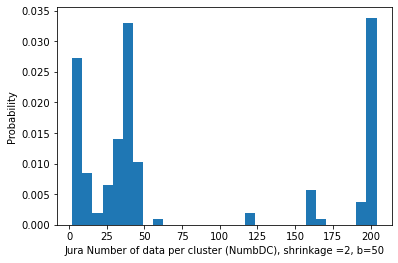

In [16]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
np.random.seed(42)
plt.hist(NumbDC, density=True, bins=30)  # `density=False` would make counts
plt.ylabel('Probability')
plt.xlabel('Jura Number of data per cluster (NumbDC), shrinkage =2, b=50');

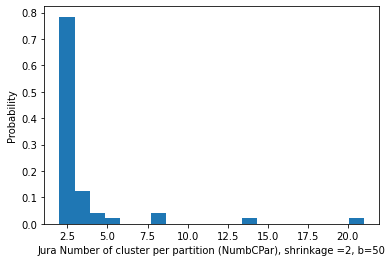

In [18]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
np.random.seed(42)
plt.hist(NumbCPar
         , density=True, bins=20)  # `density=False` would make counts
plt.ylabel('Probability')
plt.xlabel('Jura Number of cluster per partition (NumbCPar), shrinkage =2, b=50');

In [20]:
#Import libraries:
import pandas as pd
import numpy as np
import xgboost as xg
from sklearn.metrics import mean_squared_error as MSE
from sklearn.ensemble import RandomForestRegressor

In [21]:

############################################################
regressor = RandomForestRegressor(n_estimators = 10, max_depth=30, random_state = 0)
regressor.fit(covariables_train,response_train) 

# Predict the model 
rftestpred = regressor.predict(covariables_test) 
# Predict the model 
rftrainpred = regressor.predict(covariables_train)  
# xgboost test RMSE Computation 
rftestrmse = MSE(response_test, rftestpred) 
print("test xgboost MSE : % f" %(rftestrmse))

# xgboost test RMSE Computation 
rftrainrmse = MSE(response_train, rftrainpred)
print("train xgboost MSE : % f" %(rftrainrmse))


test xgboost MSE :  79.277055
train xgboost MSE :  5.713272


In [22]:
############################################################
regressor = RandomForestRegressor(n_estimators = 5, max_depth=10, random_state = 0)
regressor.fit(covariables_train,response_train) 

# Predict the model 
rftestpred = regressor.predict(covariables_test) 
# Predict the model 
rftrainpred = regressor.predict(covariables_train)  
# xgboost test RMSE Computation 
rftestrmse = MSE(response_test, rftestpred)
print("test xgboost MSE : % f" %(rftestrmse))

# xgboost test RMSE Computation 
rftrainrmse = MSE(response_train, rftrainpred)
print("train xgboost MSE : % f" %(rftrainrmse))

test xgboost MSE :  87.178588
train xgboost MSE :  5.873380
